In [3]:
#from __future__ import division
%matplotlib inline
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statistics as stat
import math
import numpy as np
from sklearn import mixture
import seaborn as sns
from haversine import haversine

In [4]:
df = pd.read_csv('./Geolife-beijing_filtered.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.head()

,dev_id,date,lat,lon,geohash,geohash_1,geohash_2,geohash_3,geohash_4,geohash_5,geohash_6
0,0,2008-10-23 02:50:00,39.984561,116.316527,386+302,193+151,129+101,97+76,77+61,39+30,19+15
1,0,2008-10-23 02:55:00,39.984456,116.306047,382+302,191+151,128+101,96+76,77+61,38+30,19+15
2,0,2008-10-23 03:00:00,39.983590,116.298869,379+302,189+151,127+101,95+76,76+61,38+30,19+15
3,0,2008-10-23 03:05:00,39.951650,116.800131,594+284,297+142,198+95,149+71,119+57,59+29,30+14
4,0,2008-10-23 03:10:00,39.951650,116.800131,594+284,297+142,198+95,149+71,119+57,59+29,30+14


In [7]:
def identify_known_places(fr, level, op):    
    
    """
    Identify the favorite locations of the individual based on her visitation frequency to the distinct locations.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    level : Float
        the visitation frequency threshold.
        
    op : Integer
        0 : to select the known places according to the maximum visitation frequency value.
        1 : to select the known places according to the average visitation frequency value.
    
    Returns
    -------
    List of geohash
         the list of locations knowns by the individual.
         
    """
        
    if op == 0:
        dist_freq = np.max(fr[['geohash','date']].groupby('geohash').count().date.values)
        
    elif op == 1:
        dist_freq = np.mean(fr[['geohash','date']].groupby('geohash').count().date.values)
    
    tab_visit = fr[fr.groupby('geohash')['geohash'].transform('count') >= dist_freq * level]['geohash'].unique()
        
    return tab_visit

In [8]:
########## testing "identify_known_places(fr, level)" ##########
df1=df.set_index(['dev_id'])
list_usr=df1.index
list_usr=list_usr.drop_duplicates()

k=list_usr[1]
fr = df1.loc[k]
level = 0.9
op = 0
print(identify_known_places(fr, level, op))

['441+288' '407+292' '392+309']


In [69]:
def number_of_successive_visits(fr, tab_visit):
    """
    Compute the number of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of integers
        the table of successive explorations of the individual.
        
    List of integers
        the table of successive returns of the individual.
        
    """
    #['date','lat','lon','geohash','geohash_1','geohash_2','geohash_3','geohash_4','geohash_5','geohash_6']
    idx = fr.groupby('geohash').first().reset_index()
    idx['is_exp'] = idx['geohash'].transform(lambda x: True if x not in tab_visit else False)
    fr = pd.merge(fr, idx, how = 'left')
    fr = fr.fillna(value=False)
    
    l = fr.groupby(fr['is_exp'].ne(fr['is_exp'].shift()).cumsum())['is_exp'].transform('size') * np.where(fr['is_exp'], 1, -1)
    l = l.loc[l.diff() != 0] 
    
    return l[l >= 0], -l[l < 0] #fr,
    

In [70]:
df1=df.set_index(['dev_id'])
list_usr=df1.index
list_usr=list_usr.drop_duplicates()

k=list_usr[1]
fr = df1.loc[k]
level = 0.9
op = 0
tab_visit=identify_known_places(fr, level, op)
dist_exp, dist_ret =number_of_successive_visits(fr, tab_visit)

In [71]:
ll.head(5)

,date,lat,lon,geohash,geohash_1,geohash_2,geohash_3,geohash_4,geohash_5,geohash_6,is_exp
0,2008-10-23 05:50:00,39.984741,116.320037,388+302,194+151,130+101,97+76,78+61,39+30,19+15,True
1,2008-10-23 05:55:00,39.979550,116.323046,389+299,195+150,130+100,98+75,78+60,39+30,20+15,True
2,2008-10-23 06:00:00,39.978532,116.327277,391+299,195+150,131+100,98+75,78+60,39+30,20+15,True
3,2008-10-23 06:05:00,39.959073,116.443470,441+288,220+144,147+96,110+72,88+58,44+29,22+15,False
4,2008-10-23 06:10:00,39.959073,116.443470,441+288,220+144,147+96,110+72,88+58,44+29,22+15,False


In [59]:
def intermittency_degreeOfReturn(fr, tab_visit):
    """
    Compute the intermittency and degree of return per individual given their trajectory.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the'date' and the 'geohash'.
    
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of float
        the table the waiting time of the individual.
        
    List of float
        the table the waiting time of the individual.
        
    """

    dist_exp, dist_ret = number_of_successive_visits(fr, tab_visit)
    
    m_exp = np.mean(dist_exp)
    m_ret = np.mean(dist_ret)
    
    return m_exp + m_ret, math.degrees(np.arctan(m_ret / m_exp))

In [60]:
inter, deg = intermittency_degreeOfReturn(fr, tab_visit)

In [212]:
def mobility_profiling(df, NB_CLUSTER, level, op):
    """
    Compute the waiting time per individual given their trajectory.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    """
    g0, g1, g2 = [], [], []
    tab1_x, tab2_x, tab3_x = [], [], []
    tab1_y, tab2_y, tab3_y = [], [], []

    
    g = df.groupby('dev_id').apply(lambda x: intermittency_degreeOfReturn(x[:8000], [])) #identify_known_places(x, level, op)))
    inter,deg_ret = map(np.array,zip(* g.values)) 
    min_inter, max_inter = min(inter), max(inter) 
    min_deg_ret, max_deg_ret = min(deg_ret), max(deg_ret) 
    inter = (inter - min_inter) / (max_inter -  min_inter)
    deg_ret = (deg_ret - min_deg_ret) / (max_deg_ret - min_deg_ret)
    
    
    labels = range(0, len(g)) 

    gmm = mixture.GaussianMixture(covariance_type = "full", n_components = NB_CLUSTER).fit(np.array([deg_ret, inter]).T)
    labels_nb = gmm.predict(np.array([ deg_ret, inter]).T)

    exp = min(deg_ret)
    ret = max(deg_ret)
    
    for i in range(0,len(g)):
        if deg_ret[i] == exp:
            explorers = labels_nb[i]
        elif deg_ret[i] == ret:
            returners = labels_nb[i]

    for i in range(0,len(labels_nb)):
        if labels_nb[i] == explorers:
            tab1_x.append(deg_ret[i])
            tab1_y.append(inter[i])

        elif labels_nb[i] == returners:
            tab2_x.append(deg_ret[i])
            tab2_y.append(inter[i])
        else:
            tab3_x.append(deg_ret[i])
            tab3_y.append(inter[i])


    plt.rcParams.update(plt.rcParamsDefault)        
    plt.scatter(tab1_x, tab1_y, marker = 'X', s = 150, c = '#e41a1c',label = 'Scouters')

    plt.scatter(tab2_x, tab2_y, marker = 'd', s = 150, c = '#4daf4a',label = 'Routiners')
    plt.scatter(tab3_x, tab3_y, marker = "8", s = 150, c = '#377eb8',label = 'Regulars')

    plt.xlabel("Deg of ret "+r'$\alpha$'+"=arctn(#R/#E)", fontsize = 24,fontweight = 'bold')
    plt.ylabel("Inter "+r'$\mu$'+"=#R+#E", fontsize = 24,fontweight = 'bold')
    plt.legend(prop = {'size': 22, 'weight':'bold'})

    plt.show()
    
    return g0, g1, g2



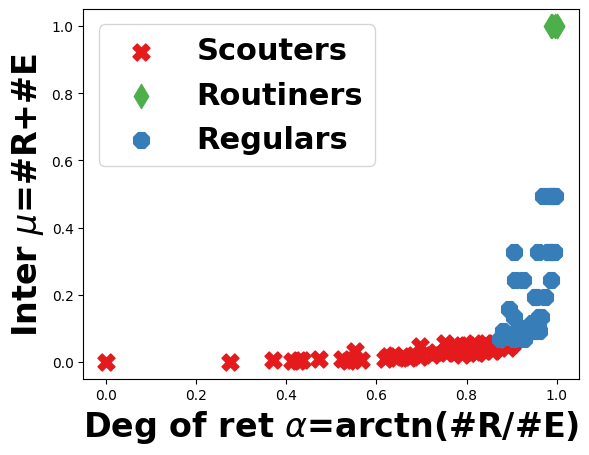

([], [], [])

In [213]:
mobility_profiling(df, 3, 0.95, 0)

In [248]:
def waiting_time(fr):
    """
    Compute the waiting time per individual given their trajectory.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of float
        the table the waiting time of the individual.
        
    """
    #cols = ['geohash']
    #cols = ['lat','lon','geohash','geohash_1','geohash_2','geohash_3','geohash_4','geohash_5','geohash_6']
    fr = fr.loc[(fr['geohash'].shift() != fr['geohash'])]
    fr = fr.reset_index()
    fr= fr.set_index('date')
    #fr['tvalue'] = fr.index
    ser_diff = fr.index.to_series().diff()
    
    return ser_diff

In [249]:
ll=waiting_time(fr)


In [250]:
ll

date
2008-10-23 05:50:00               NaT
2008-10-23 05:55:00   0 days 00:05:00
2008-10-23 06:00:00   0 days 00:05:00
2008-10-23 06:05:00   0 days 00:05:00
2008-10-24 02:00:00   0 days 19:55:00
                            ...      
2008-12-15 00:23:57   0 days 00:01:01
2008-12-15 00:26:03   0 days 00:02:06
2008-12-15 00:27:03   0 days 00:01:00
2008-12-15 00:28:05   0 days 00:01:02
2008-12-15 00:29:06   0 days 00:01:01
Name: date, Length: 3797, dtype: timedelta64[ns]

In [ ]:
map(sub, a, b)

In [165]:
k

array([5.06932897e-03, 6.75409918e-03, 1.31807740e-02, 4.02215955e-03,
       1.19853788e-02, 3.09111353e-02, 5.92693364e-03, 2.90992686e-03,
       2.90938455e-03, 2.71165851e-02, 3.91138138e-02, 6.70164286e-03,
       1.75164454e-02, 3.09773428e-02, 8.24387485e-03, 1.95123001e-02,
       6.32420376e-03, 4.20830416e-03, 4.20394973e-03, 8.27654969e-04,
       4.99471315e-02, 1.48263520e-02, 1.38666752e-02, 3.06422851e-03,
       5.93933945e-03, 1.00970694e-02, 8.16217386e-03, 1.09572126e-02,
       9.84335729e-03, 1.35346171e-02, 1.94839779e-03, 4.72060725e-03,
       2.32815201e-02, 8.84854135e-03, 3.88463784e-03, 1.33324544e-02,
       4.62288878e-03, 2.35174056e-02, 0.00000000e+00, 1.15729194e-02,
       1.21196283e-02, 2.12691963e-02, 5.48472234e-02, 2.27002682e-03,
       1.91059538e-02, 1.00000000e+00, 5.47072358e-01, 1.46908479e-02,
       1.43141285e-03, 1.32111479e-01, 2.01709468e-02, 2.03626547e-02,
       1.30599248e-02, 1.79098061e-02, 4.00051159e-02, 4.33054183e-02,
      

In [112]:
def number_of_successive_visits(fr, tab_visit):
    """
    Compute the number of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of integers
        the table of successive explorations of the individual.
        
    List of integers
        the table of successive returns of the individual.
        
    """
    
    dist_exp = []
    dist_ret = []
    
    cmp_exp = 0
    cmp_ret = 0

    for i in fr.index:
        if cmp_day == 0:  # begining of the trace 
            prev_visit = i[1]
            prev_day = i[0].date()
            cmp_day = 1

        elif (i[0].date() - prev_day).days > 1:  # if there is no record within the last 24 h
                prev_day = i[0].date()
                cmp_day = cmp_day + 1
                if cmp_exp > 0:
                    dist_exp.append(cmp_exp) 
                    cmp_exp = 0
                if cmp_ret > 0:
                    dist_ret.append(cmp_ret)
                    cmp_ret = 0 

        else:
            if i[1] not in tab_visit and  cmp_ret > 0:
                dist_ret.append(cmp_ret)
                cmp_ret = 0

            elif i[1] in tab_visit and cmp_exp > 0:
                dist_exp.append(cmp_exp)
                cmp_exp = 0   

        if i[1] not in tab_visit:
            cmp_exp = cmp_exp + 1
            tab_visit.append(i[1])
        else:
            cmp_ret = cmp_ret + 1

        if i[0].date().day != prev_day.day:
            cmp_day = cmp_day + 1
        prev_visit = i[1]

    if cmp_ret > 0: 
        dist_ret.append(cmp_ret)

    if cmp_exp > 0:    
        dist_exp.append(cmp_exp)

    return dist_exp, dist_ret


In [106]:
def waiting_time(fr, NB_DAY):
    """
    Compute the waiting time per individual given their trajectory.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of float
        the table the waiting time of the individual.
        
    """

    dist_w_t = []
    cmp_day = 0

    for i in fr.index:
        if cmp_day <= NB_DAY:  # number of days
            if cmp_day == 0: # begining of the trace 
                prev_visit = i[1]
                prev_day = i[0].date()
                cmp_day = 1
            elif (i[0].date() - prev_day).days > 1:    # if there is no record within the last 24 h
                    prev_day = i[0].date()
                    cmp_day = cmp_day + 1
                    dist_w_t.append((24 - (last.hour)) * 60)
            else:
                if prev_visit != i[1]:
                    dist_w_t.append(((i[0]) - (last)).total_seconds() / 60)                       
            
            if i[0].date().day != prev_day.day:
                cmp_day = cmp_day + 1
                
            prev_visit = i[1]
            last = i[0]
        
    return dist_w_t

In [ ]:
def mobility_profiling(df, tab_visit, NB_DAY, NB_CLUSTER):
    """
    Compute the waiting time per individual given their trajectory.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    """
    
    features = dict()
    features['inter'] = []
    features['deg_ret'] = []
    
    g0 = []
    g1 = []
    g2 = []

    tab1_x = []
    tab1_y = []
    tab2_x = []
    tab2_y = []
    tab3_x = []
    tab3_y = []
    
    list_usr = df.index
    list_usr = list_usr.drop_duplicates()
    
    for k in list_usr:
        fr = df.loc[k]
        fr = fr.sort_values(by = 'date')    
        fr = fr.set_index(['date','geohash'])
        
        a, b = intermittency_degreeOfReturn(fr, tab_visit, NB_DAY)
        
        features['inter'].append(a)
        features['deg_ret'].append(b)

        
    
    x_max_a = max(features.get('inter'))
    x_min_a = min(features.get('inter'))

    x_max_b = max(features.get('deg_ret'))
    x_min_b = min(features.get('deg_ret'))


    for i in range(0, len(features.get('inter'))):
        features.get('inter')[i] = (features.get('inter')[i] - x_min_a) / (x_max_a - x_min_a)
        features.get('deg_ret')[i] = (features.get('deg_ret')[i] - x_min_b) / (x_max_b - x_min_b)
        

    
    labels = range(0, len(list_usr)) 

    gmm = mixture.GaussianMixture(covariance_type="full", n_components = NB_CLUSTER).fit(np.array([features.get('deg_ret'),features.get('inter')]).T)
    labels_nb = gmm.predict(np.array([ features.get('deg_ret'),features.get('inter')]).T)

    exp = min(features.get('deg_ret'))
    ret = max(features.get('deg_ret'))
    
    for i in range(0,len(labels_nb)):
        if features.get('deg_ret')[i] == exp:
            explorers = labels_nb[i]
        elif features.get('deg_ret')[i] == ret:
            returners = labels_nb[i]

    for i in range(0,len(labels_nb)):
        if labels_nb[i] == explorers:
            tab1_x.append(features.get('deg_ret')[i])
            tab1_y.append(features.get('inter')[i])

        elif labels_nb[i] == returners:
            tab2_x.append(features.get('deg_ret')[i])
            tab2_y.append(features.get('inter')[i])
        else:
            tab3_x.append(features.get('deg_ret')[i])
            tab3_y.append(features.get('inter')[i])


    plt.rcParams.update(plt.rcParamsDefault)        
    plt.scatter(tab1_x, tab1_y, marker = 'X', s = 150, c = '#e41a1c',label = 'Scouters')

    plt.scatter(tab2_x, tab2_y, marker = 'd', s = 150, c = '#4daf4a',label = 'Routiners')
    plt.scatter(tab3_x, tab3_y, marker = "8", s = 150, c = '#377eb8',label = 'Regulars')

    plt.xlabel("Deg of ret "+r'$\alpha$'+"=arctn(#R/#E)", fontsize = 24,fontweight = 'bold')
    plt.ylabel("Inter "+r'$\mu$'+"=#R+#E", fontsize = 24,fontweight = 'bold')
    plt.legend(prop = {'size': 22, 'weight':'bold'})

    plt.show()
    
    return g0, g1, g2


In [108]:
def duration_of_successive_visits(fr, tab_visit, NB_DAY):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    List of integers
        the table of duration of successive returns of the individual.
        
    """

    for i in fr.index:  
        if cmp_day <= NB_DAY:
            if cmp_day == 0: 
                prev_day = i[0].date()
                cmp_day = 1
                    
            else:
                if (i[0].date() - prev_day).days > 1: # if there is no record within the last 24 h
                    if is_exp == 1:
                        dist_exp.append(((last) - (start_visit)).total_seconds() / 60) 
                        is_exp = 0
                    if is_ret == 1:
                        dist_ret.append(((last) - (start_visit)).total_seconds() / 60)
                        is_ret = 0
                    start_visit = i[0]
                    
                if i[1] in tab_visit: # in case of a return visit
                    if is_exp == 1:
                        dist_exp.append(((i[0]) - (start_visit)).total_seconds() / 60)
                        is_exp = 0
                        start_visit = i[0]
                    is_ret = 1
                    
                else:                # in case of a exploration visit
                    if is_ret == 1: 
                        dist_ret.append(((i[0]) - (start_visit)).total_seconds() / 60)
                        is_ret = 0
                        start_visit = i[0]
                    is_exp = 1
                    tab_visit.append(i[1])
                        
                        
                last = i[0]
                if i[0].date().day != prev_day.day:
                    cmp_day = cmp_day + 1
                    prev_day = i[0].date()


    if is_ret == 1 : 
        dist_ret.append(((last) - (start_visit)).total_seconds() / 60)
    if is_exp == 1:    
        dist_exp.append(((last) - (start_visit)).total_seconds() / 60)

       
    return dist_exp, dist_ret


In [111]:
def distance_of_successive_visits(fr, tab_visit, NB_DAY):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    List of integers
        the table of duration of successive returns of the individual.
        
    """
    dist_exp = []
    dist_ret = []
    
    is_exp = 0
    is_ret = 0
    
    walk_exp = 0
    walk_return = 0
    
    cmp_day = 0
    

    for i in fr.index:
        if cmp_day <= NB_DAY:
            if cmp_day == 0:
                prev_day = i[3].date()   
                prev_visit = i[0]
                prev_lat = i[1]
                prev_lon = i[2]
                cmp_day = 1  
            
            else:
                if (i[3].date() - prev_day).days > 1:   # if there is no record within the last 24 h
                    if walk_exp > 0: 
                        dist_exp.append(walk_exp)
                        walk_exp = 0
                        is_exp = 0
                                        
                    if walk_return > 0:
                        dist_ret.append(walk_return)
                        walk_return = 0
                        is_ret = 0
                    
                else:
                    if i[0] not in tab_visit:
                        if is_ret == 1:
                            if prev_visit != i[0]:
                                walk_return = walk_return + haversine((i[1],i[2]),(prev_lat,prev_lon))
                                dist_ret.append(walk_return)
                            is_ret = 0
                            walk_ret = 0   
                            
                        is_exp = 1
                        tab_visit.append(i[0])    
                        walk_exp = walk_exp + haversine((i[1],i[2]),(prev_lat,prev_lon))
                        
                    else:
                        if is_exp == 1: 
                            walk_exp = walk_exp + haversine((i[1],i[2]),(prev_lat,prev_lon))
                            dist_exp.append(walk_exp)
                            is_exp = 0  
                            walk_exp = 0
                            
                        is_ret = 1
                        if prev_visit != i[0]:
                            walk_return = walk_return + haversine((i[1],i[2]),(prev_lat,prev_lon))
                      
                if i[3].date().day != prev_day.day:
                    cmp_day = cmp_day + 1
                    
            prev_visit = i[0]           
            prev_lat = i[1]
            prev_lon = i[2]
            prev_day = i[3].date()                                          
          
    return dist_exp, dist_ret

In [ ]:
def jump_size(fr, NB_DAY):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    List of integers
        the table of duration of successive returns of the individual.
        
    """
    dist = []
    cmp_day = 0
    
    for i in fr.index:
        if cmp_day <= NB_DAY:
            if cmp_day == 0:
                prev_place = i[0]
                prev_lat = i[1]
                prev_lon = i[2]
                cmp_day = 1
                
            else:  
                if i[0] != prev_place:
                    dist.append(haversine((i[1],i[2]),(prev_lat,prev_lon)))
            
            if (i[3].date() - prev_day).days > 1:
                cmp_day = cmp_day + 1
            
            prev_place = i[0]            
            prev_lat = i[1]
            prev_lon = i[2]  
            prev_date = i[3].date()
            
    return dist
            

In [112]:
def number_of_stops(fr, NB_DAY):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    List of integers
        the table of duration of successive returns of the individual.
        
    """
    
    
    nb_stops = fr['geohash'].value_counts()
    
    fr_uniq = fr[fr.groupby('geohash').x.transform(len) == 1]
    
    return nb_stops, len(fr_uniq) / nb_stops



In [ ]:
def number_of_transitions(fr):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    """
    
    fr_transition = fr.loc[fr.shift() != fr]
    
    return len(fr_transition)

In [ ]:
def visitation_frequency(fr):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    """
    fr = fr.sort_values(by = 'date') 
    dist_freq = fr[['geohash','date']].groupby('geohash').count().date.values
    
    return dist_freq

In [ ]:
def radius_of_gyration(fr):
    """
    Compute the duration of successive explorations and successive returns per individual given their trajectory and set of known places.
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual consisting of the 'date' and the 'geohash'.
        
    NB_DAY : Constant
        the number.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    """

    
    center_of_mass = np.mean([fr.lat, fr.lon], axis=0)
    rg = np.sqrt(np.mean([haversine((lat, lng), center_of_mass) ** 2.0 for lat, lon in [fr.lat, fr.lon]]))
    return rg

In [22]:




nb_measure=[]

# Number of successive explorations
features['nb_e_m'] = [] # mean
features['nb_e_sd'] = [] # standard devidation
features['nb_e_cv'] = [] # coefficient of variation

# Number of successive returns
features['nb_r_m'] = []
features['nb_r_sd'] = []
features['nb_r_cv'] = []

# Number of successive and disctinct visits
features['nb_d_m'] = []
features['nb_d_sd'] = []
features['nb_d_cv'] = []

# Waiting time
features['wait_time_m'] = []
features['wait_time_sd'] = []
features['wait_time_cv'] = []

for k in list_usr:
    
        #distributions
        dist_exp = []
        dist_ret = []
        dist_d = []
        dist_w_t = []
        
        tab_visit=[]
        #tab_visit = known_places.get(k)

        cmp_exp = 0
        cmp_ret = 0
        cmp_d = 0
        
        cmp_day = 0
        
        #cmp_measure = 0
        
        fr = df1.loc[k]
        fr = fr.sort_values(by = 'date')    
        fr = fr.set_index(['date','geohash'])

        for i in fr.index:
            if cmp_day <= 10:  # number of days
                #cmp_measure = cmp_measure + 1
                
                if cmp_day == 0: # begining of the trace 
                    prev_visit = i[1]
                    prev_day = i[0].date()
                    last = i[0]
                    
                    if i[1] not in tab_visit:
                        cmp_exp = cmp_exp + 1
                        tab_visit.append(i[1])
                    else:
                        cmp_ret = cmp_ret + 1
                        cmp_d = cmp_d + 1 
                        
                    cmp_day = 1
                    
                elif (i[0].date()-prev_day).days > 1:    # if there is no record within the last 24 h
                        cmp_day = cmp_day + 1
                        prev_day = i[0].date()
                        
                        if cmp_exp > 0:
                            dist_exp.append(cmp_exp) 
                            cmp_exp = 0
                        
                        if cmp_ret > 0:
                            dist_ret.append(cmp_ret)
                            cmp_ret = 0 
                            dist_d.append(cmp_d)
                            cmp_ret_dist = 0 
                        
                        dist_w_t.append((24 - (last.hour)) * 60)
                            
                        if i[1] in tab_visit:
                            cmp_ret = cmp_ret + 1
                            cmp_d = cmp_d + 1 
                        else:
                            cmp_exp = cmp_exp + 1
                            tab_visit.append(i[1])
                            
                        last = i[0]
    
                else:
            
                    if i[1] in tab_visit: # in case of a return visit     
                        if cmp_exp > 0:
                            dist_exp.append(cmp_exp)
                            cmp_exp = 0
                            dist_w_t.append(((i[0])-(last)).total_seconds() / 60)

                        if i[1] != prev_visit:
                            dist_w_t.append(((i[0]) - (last)).total_seconds() / 60)
                            
                        last = i[0]
                        cmp_ret = cmp_ret + 1
                        
                    else:  
                        if cmp_ret > 0:
                            dist_ret.append(cmp_ret)
                            dist_d.append(cmp_d)
                            cmp_ret = 0
                            cmp_d = 0 
                            dist_w_t.append(((i[0]) - (last)).total_seconds() / 60)
                            
                        last = i[0]
                        cmp_exp = cmp_exp + 1
                        tab_visit.append(i[1])
                                 
            if i[0].date().day != prev_day.day:
                cmp_day = cmp_day + 1
            prev_visit = i[1]

        #nb_measure.append(cmp_measure) 
        
        #if i[0]!=last:
        #    dist_w_t.append(((i[0])-(last)).total_seconds()/60)
        
        
        #if cmp_day >= 30: # if the number of total days of analysis is reached
        
        if cmp_ret > 0: 
            dist_ret.append(cmp_ret)

        if cmp_d > 0:
            dist_d.append(cmp_d)

        if cmp_exp > 0:    
            dist_exp.append(cmp_exp)


        if len(dist_exp) > 0:
            m_exp = stat.mean(dist_exp)

        else:
            m_exp = 0
        if len(dist_exp) > 1:
            sig_exp = stat.stdev(dist_exp, m_exp)
            cv_exp = (sig_exp / m_exp) * 100
        else:
            cv_exp = 0     


        m_ret = stat.mean(dist_ret)
        if len(dist_ret) > 1:
            sig_ret = stat.stdev(dist_ret, m_ret)
            cv_ret = (sig_ret / m_ret) * 100
        else:
            cv_ret = 0


        m_d = stat.mean(dist_d)
        if len(dist_d) > 1:
            sig_d = stat.stdev(dist_d, m_d)
            if m_d > 0:
                cv_d = (sig_d / m_d) * 100
            else:
                cv_d = 0
        else:
            cv_d = 0

        if len(dist_w_t) > 0:
            m_w_t = stat.mean(dist_w_t)
        else:
            m_w_t = 0
        if len(dist_w_t) > 1:
            sig_w_t = stat.stdev(dist_w_t, m_w_t)
            if m_w_t > 0:
                cv_w_t = (sig_w_t / m_w_t) * 100
            else:
                cv_w_t = 0
        else:
            cv_w_t = 0

        features.get('nb_e_m').append((m_exp))
        features.get('nb_e_sd').append((sig_exp))
        features.get('nb_e_cv').append(cv_exp)       

        features.get('nb_r_m').append((m_ret))
        features.get('nb_r_sd').append((sig_ret))
        features.get('nb_r_cv').append(cv_ret)     

        features.get('nb_d_m').append(m_d)
        features.get('nb_d_sd').append(sig_d)
        features.get('nb_d_cv').append(cv_d)        

        features.get('wait_time_m').append(m_w_t)
        features.get('wait_time_sd').append(sig_w_t)
        features.get('wait_time_cv').append(cv_w_t)

In [23]:
features['inter'] = []
features['deg_ret'] = []

for i in range(0, len(features.get('nb_e_m'))):
    if features.get('nb_e_m')[i] >  0:
        features.get('inter').append((features.get('nb_e_m')[i] + features.get('nb_r_m')[i]))
        features.get('deg_ret').append((math.degrees(np.arctan(features.get('nb_r_m')[i] / features.get('nb_e_m')[i]))))

In [24]:
features['inter_d'] = []
features['deg_ret_d'] =[ ]

for i in range(0, len(features.get('nb_e_m'))):
    if features.get('nb_e_m')[i] > 0:
        features.get('inter_d').append((features.get('nb_e_m')[i] + features.get('nb_d_m')[i]))
        features.get('deg_ret_d').append((math.degrees(np.arctan(features.get('nb_d_m')[i] / features.get('nb_e_m')[i]))))

In [25]:
x_max_a = max(features.get('inter'))
x_min_a = min(features.get('inter'))
            
x_max_b = max(features.get('deg_ret'))
x_min_b = min(features.get('deg_ret'))


x_max_a_dist = max(features.get('inter_d'))
x_min_a_dist = min(features.get('inter_d'))
            
x_max_b_dist = max(features.get('deg_ret_d'))
x_min_b_dist = min(features.get('deg_ret_d'))

In [26]:
for i in range(0, len(features.get('inter'))):
    if features.get('inter')[i] > 0 and features.get('deg_ret')[i]>0:
        features.get('inter')[i] = (features.get('inter')[i] - x_min_a) / (x_max_a - x_min_a)
        features.get('deg_ret')[i] = (features.get('deg_ret')[i] - x_min_b) / (x_max_b - x_min_b)

In [27]:
for i in range(0, len(features.get('inter_d'))):
    features.get('inter_d')[i] = (features.get('inter_d')[i] - x_min_a_dist) / (x_max_a_dist - x_min_a_dist)
    features.get('deg_ret_d')[i] = (features.get('deg_ret_d')[i] - x_min_b_dist) / (x_max_b_dist - x_min_b_dist)

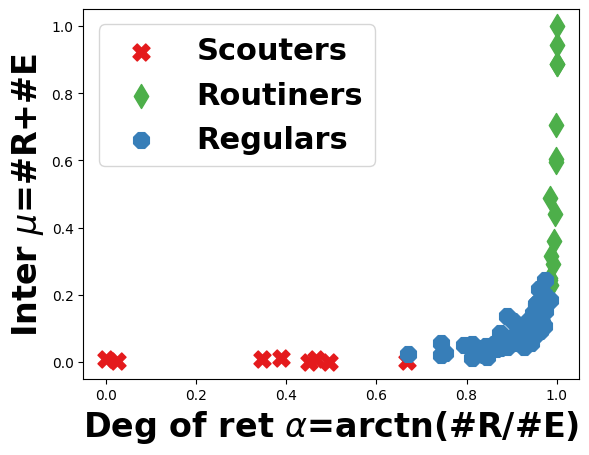

In [30]:
########################################### GAUSSIAN MIXTURE MODELS ###########################################

g0 = []
g1 = []
g2 = []

tab1_x = []
tab1_y = []
tab2_x = []
tab2_y = []
tab3_x = []
tab3_y = []

nb_clusters=3

labels = range(0, len(list_usr)) 

gmm = mixture.GaussianMixture(covariance_type="full", n_components=nb_clusters).fit(np.array([features.get('deg_ret'),features.get('inter')]).T)
labels_nb = gmm.predict(np.array([ features.get('deg_ret'),features.get('inter')]).T)


exp = min(features.get('deg_ret'))
ret = max(features.get('deg_ret'))
for i in range(0,len(labels_nb)):
    if features.get('deg_ret')[i] == exp:
        explorers = labels_nb[i]
    elif features.get('deg_ret')[i] == ret:
        returners = labels_nb[i]

for i in range(0,len(labels_nb)):
    if labels_nb[i] == explorers:
        tab1_x.append(features.get('deg_ret')[i])
        tab1_y.append(features.get('inter')[i])

    elif labels_nb[i] == returners:
        tab2_x.append(features.get('deg_ret')[i])
        tab2_y.append(features.get('inter')[i])
    else:
        tab3_x.append(features.get('deg_ret')[i])
        tab3_y.append(features.get('inter')[i])

        
plt.rcParams.update(plt.rcParamsDefault)        
plt.scatter(tab1_x, tab1_y, marker ='X', s = 150, c ='#e41a1c',label ='Scouters')

plt.scatter(tab2_x, tab2_y, marker = 'd', s = 150, c ='#4daf4a',label = 'Routiners')
plt.scatter(tab3_x, tab3_y, marker = "8", s = 150, c ='#377eb8',label = 'Regulars')

plt.xlabel("Deg of ret "+r'$\alpha$'+"=arctn(#R/#E)", fontsize = 24,fontweight = 'bold')
plt.ylabel("Inter "+r'$\mu$'+"=#R+#E", fontsize = 24,fontweight = 'bold')
plt.legend(prop={'size': 22, 'weight':'bold'})

plt.show()
#plt.savefig('./deg_reg_geolife_300', dpi=300, bbox_inches='tight')

In [31]:
for i in range(0,len(labels_nb)):
    if labels_nb[i]==explorers:
        g0.append(list_usr[i])

    elif labels_nb[i]==returners:
        g1.append(list_usr[i])

    else:
        g2.append(list_usr[i])

In [39]:
features['dur_e'] = []
features['dur_r'] = []

features['dur_e_m'] = []
features['dur_e_sd'] = []
features['dur_e_cv'] = []

features['dur_r_m'] = []
features['dur_r_sd'] = []
features['dur_r_cv'] = []

ind = 0

for k in list_usr:
    dist_exp = []
    dist_ret = []

    #tab_visit=known_places.get(k)
    tab_visit = []
    is_exp = 0
    is_ret = 0
    
    cmp_day = 0
    
    fr = df1.loc[[k]]
    fr = fr.set_index(['date','geohash'])
    fr = fr.sort_values(by = 'date')
    
    for i in fr.index:  
        if cmp_day <= 30: 
            if cmp_day == 0: 
                prev_day = i[0].date()
                #start_visit = i[0]
                cmp_day = 1
                    
            else:
                
                if (i[0].date() - prev_day).days > 1: # if there is no record within the last 24 h
                    if is_exp == 1:
                        dist_exp.append(((last) - (start_visit)).total_seconds() / 60) 
                        is_exp = 0
                    if is_ret == 1:
                        dist_ret.append(((last) - (start_visit)).total_seconds() / 60)
                        is_ret = 0

                if i[1] in tab_visit: # in case of a return visit
                    if is_exp == 1:
                        dist_exp.append(((i[0]) - (start_visit)).total_seconds() / 60)
                        is_exp = 0
                    is_ret = 1
                    
                else:                # in case of a exploration visit
                    if is_ret == 1: 
                        dist_ret.append(((i[0]) - (start_visit)).total_seconds() / 60)
                        is_ret = 0
                    is_exp = 1
                    tab_visit.append(i[1])
                        
                        
                start_visit = i[0]
                last = i[0]
                
                if i[0].date().day != prev_day.day:
                    cmp_day = cmp_day + 1
                    prev_day = i[0].date()


    if is_ret == 1 : 
        dist_ret.append(((last) - (start_visit)).total_seconds() / 60)
    if is_exp == 1:    
        dist_exp.append(((last) - (start_visit)).total_seconds() / 60)

        
    m_exp = stat.mean(dist_exp)
    if len(dist_exp) > 1:
        sig_exp = stat.stdev(dist_exp, m_exp)
    else:
        sig_exp = 0

    if m_exp > 0:
        cv_exp = (sig_exp / m_exp) * 100
    else:
        cv_exp = 0


    m_ret = stat.mean(dist_ret)
    if len(dist_ret) > 1:
        sig_ret=stat.stdev(dist_ret, m_ret)
    else:
        sig_ret = 0

    if m_ret > 0:
        cv_ret = (sig_ret / m_ret) * 100
    else:
        cv_ret = 0

        
    features.get('dur_e').append(sum(dist_exp))
    features.get('dur_r').append(sum(dist_ret))
    
    features.get('dur_e_m').append(m_exp)
    features.get('dur_e_sd').append(sig_exp)
    features.get('dur_e_cv').append(cv_exp)
    
    features.get('dur_r_m').append(m_ret)
    features.get('dur_r_sd').append(sig_ret)
    features.get('dur_r_cv').append(cv_ret)

In [43]:
features['dist_e'] = []
features['dist_r'] = []

features['dist_e_m'] = []
features['dist_e_sd'] = []
features['dist_e_cv'] = []

features['dist_r_m'] = []
features['dist_r_sd'] = []
features['dist_r_cv'] = []

features['dist_m'] = []
features['dist_sd'] = []
features['dist_cv'] = []


ind = 0

for k in list_usr:
    fr = df1.loc[[k]]
    fr = fr.set_index(['geohash','lat','lon','date'])
    fr = fr.sort_values(by ='date')
    
    dist_exp = []
    dist_ret = []
    dist_trans = []
    
    #tab_visit=known_places.get(k)
    tab_visit = []

    is_exp = 0
    is_ret = 0
    
    walk_exp = 0
    walk_return = 0
    
    cmp_day = 0
    

    for i in fr.index:
        if cmp_day <= 30:
            if cmp_day == 0:
                prev_day = i[3].date()   
                prev_visit = i[0]
                prev_lat = i[1]
                prev_lon = i[2]
                cmp_day = 1  
            
            else:
                if (i[3].date() - prev_day).days > 1:   # if there is no record within the last 24 h
                    if walk_exp > 0: 
                        dist_exp.append(walk_exp)
                        walk_exp = 0
                        is_exp = 0
                                        
                    if walk_return > 0:
                        dist_ret.append(walk_return)
                        walk_return = 0
                        is_ret = 0
                    
                else:
                    if i[0] in tab_visit:
                        if is_exp == 1: 
                            walk_exp = walk_exp + haversine((i[1],i[2]),(prev_lat,prev_lon))
                            dist_exp.append(walk_exp)
                            is_exp = 0  
                            walk_exp = 0
                            
                            dist_trans.append(haversine((i[1],i[2]),(prev_lat,prev_lon)))    

                        is_ret = 1
                        walk_return = walk_return + haversine((i[1],i[2]),(prev_lat,prev_lon))

                    else:
                        if is_ret == 1:
                            walk_return = walk_return + haversine((i[1],i[2]),(prev_lat,prev_lon))
                            dist_ret.append(walk_return)
                            is_ret = 0
                            walk_ret = 0   
                            
                            dist_trans.append(haversine((i[1],i[2]),(prev_lat,prev_lon))) 
                        
                        is_exp = 1
                        tab_visit.append(i[0])    
                        walk_exp = walk_exp + haversine((i[1],i[2]),(prev_lat,prev_lon))
                                                 

                if i[3].date().day != prev_day.day:
                    cmp_day = cmp_day + 1
                    
            prev_visit = i[0]           
            prev_lat = i[1]
            prev_lon = i[2]
            prev_day = i[3].date()
                                                  
                                                  
    if len(dist_trans) > 0:
        m_trans = stat.mean(dist_trans)
    else:
        m_trans = 0

    if len(dist_trans) > 1:
        sig_trans = stat.stdev(dist_trans, m_trans)
    elif len(dist_trans) == 1:
        sig_trans = dist_trans[0]
    else:
        sig_trans = 0

    if m_trans > 0:
        cv_trans = (sig_trans / m_trans) * 100
    else:
        cv_trans = 0                                             
                                                  

    if len(dist_exp) > 0:
        m_exp = stat.mean(dist_exp)
    else:
        m_exp = 0

    if len(dist_exp) > 1:
        sig_exp = stat.stdev(dist_exp, m_exp)
    elif len(dist_exp) == 1:
        sig_exp = dist_exp[0]
    else:
        sig_exp = 0

    if m_exp > 0:
        cv_exp = (sig_exp / m_exp) * 100
    else:
        cv_exp = 0


    if len(dist_ret) > 0:
        m_ret = stat.mean(dist_ret)
    else:
        m_ret = 0

    if len(dist_ret) > 1:
        sig_ret = stat.stdev(dist_ret, m_ret)
    elif len(dist_ret) == 1:
        sig_ret = dist_ret[0]
    else:
        sig_ret = 0

    if m_ret > 0:
        cv_ret = (sig_ret / m_ret) * 100
    else:
        cv_ret = 0

    
    features.get('dist_e').append(sum(dist_exp))
    features.get('dist_r').append(sum(dist_ret))
    
    features.get('dist_e_m').append(m_exp)
    features.get('dist_r_m').append(m_ret)

    features.get('dist_e_sd').append(sig_exp)
    features.get('dist_r_sd').append(sig_ret)
    
    features.get('dist_e_cv').append(cv_exp)
    features.get('dist_r_sd').append(cv_ret)

In [44]:
features['jump_m'] = []
features['jump_sd'] = []
features['jump_cv'] = []
features['jump_total'] = []

for k in list_usr:
    fr = df1.loc[[k]]
    fr = fr.set_index(['geohash','lat','lon','date'])
    fr = fr.sort_values(by = 'date')
    
    dist = []
    is_dist = 0
    cmp_day = 0
    
    for i in fr.index:
        if cmp_day <= 30:
            if cmp_day == 0:
                prev_place = i[0]
                prev_lat = i[1]
                prev_lon = i[2]
                is_dist = 1
                cmp_day = 1
                
            else:
                if (i[3].date() - prev_day).days <= 1:   
                    if i[0] != prev_place:
                        dist.append(haversine((i[1],i[2]),(prev_lat,prev_lon)))
            
            if (i[3].date() - prev_day).days > 1:
                cmp_day = cmp_day + 1
            
            prev_place = i[0]            
            prev_lat = i[1]
            prev_lon = i[2]  
            prev_date = i[3].date()  
            
                
    if len(dist) > 0:
        m = stat.mean(dist)
    else:
        m = 0

    if len(dist) > 1:
        sig = stat.stdev(dist, m)
    elif len(dist) == 1:
        sig_exp = dist[0]
    else:
        sig = 0

    if m > 0:
        cv = (sig_exp / m) * 100
    else:
        cv = 0
                
    features.get('jump_m').append(m)
    features.get('jump_sd').append(sig)
    features.get('jump_cv').append(cv)
    features.get('jump_total').append(sum(dist))

In [45]:
features['ratio_uniq'] = []

features['nb_stop'] = []

for k in list_usr:
    fr = df1.loc[k]
    fr = fr.set_index(['date','geohash'])
    fr = fr.sort_values(by = 'date')
    
    cmp_day = 0
    tab_visit = dict()
    nb_uniq = 0
    
    for i in fr.index:
        if cmp_day <= 30: 
            if cmp_day == 0:
                cmp_day = cmp_day + 1
                tab_visit[i[1]] = 1
                prev_day = i[0].date()
            
            else:
                if i[1] in tab_visit:
                    tab_visit[i[1]] = tab_visit.get(i[1]) + 1
                else:
                    tab_visit[i[1]] = 1
   
            if i[0].date().day != prev_day.day:
                    cmp_day = cmp_day + 1
                
            prev_day = i[0].date()
            
    nb_place = len(tab_visit.keys())
    
    for j in tab_visit.keys():
        if tab_visit.get(j) == 1:
            nb_uniq = nb_uniq + 1

    features.get('ratio_uniq').append(nb_uniq/nb_place)
    features.get('nb_stop').append(nb_place)
    

In [46]:
features['nb_trans'] = []

for k in list_usr:
    dist_mv = []

    cmp_mv = 0
    cmp_day = 0
    
    fr = df1.loc[k]
    fr = fr.sort_values(by = 'date')    
    fr = fr.set_index(['date','geohash'])

    for i in fr.index:
        if cmp_day <= 30:        #tabE[k]:
            if cmp_day == 0:
                prev_visit = i[1]
                cmp_day = 1
                prev_day = i[0].date()
                
            else:
                if prev_day.day != i[0].date().day:
                    cmp_day = cmp_day + 1
                    prev_day = i[0].date()
            #if known place
            if i[1] != prev_visit:     
                cmp_mv = cmp_mv + 1
            prev_visit = i[1]
       
    features.get('nb_trans').append(cmp_mv)        

In [47]:
features['visit_freq_m'] = []
features['visit_freq_cv'] = []

for k in list_usr:
    
    fr = df1.loc[k]
    fr = fr.sort_values(by = 'date') 
    dist_freq = fr[['geohash','date']].groupby('geohash').count().date.values
    
    if len(dist_freq) > 0:
        m_freq = stat.mean(dist_freq)
    else:
        m_freq = 0
        
    if len(dist_freq) > 1:
        sig_freq = stat.stdev(dist_freq, m_freq)
        cv_freq = (sig_freq / m_freq) * 100
    else:
        cv_freq = 0

    features.get('visit_freq_m').append(m_freq)
    features.get('visit_freq_cv').append(cv_freq)

In [48]:
rcm = dict() #dico containing the center of mass of each individual
rg = dict() #dico containing the radius of gyration of each individual
rg_t = dict() #dico containing the radius of gyration of each individual according to the duration of stay
maxd = dict()

for k in list_usr:
    rcm[k] = dict()
    rg[k] = dict()
    rg_t[k] = dict()
    maxd[k] = dict()
    
    rcm[k]['lat'] = df1.loc[k].lat.mean()
    rcm[k]['lon'] = df1.loc[k].lon.mean()
    rg[k] = 0.0
    rg_t[k] = 0.0
    maxd[k]['lat'] = 0.0
    maxd[k]['lon'] = 0.0
    

for k in list_usr:
    valmax = 0.0
    cmp = 0
    fr = df1.loc[[k]]
    fr = fr.set_index(['lat','lon'])
    fr = fr.sort_values(by = 'date')
    for i in fr.index:
        cmp += 1
        rg[k] = rg[k] + haversine((i[0],i[1]), (rcm[k]['lat'],rcm[k]['lon'])) ** 2

        temp = haversine((i[0],i[1]), (rcm[k]['lat'],rcm[k]['lon']))
        if temp > valmax:
            maxd[k]['lat'] = i[0]
            maxd[k]['lon'] = i[1]
            valmax = temp

    rg[k] = math.sqrt((rg[k]) / cmp)
    

In [49]:
features['rg']=[]

for k in list_usr:
    features.get('rg').append(rg.get(k))

In [50]:
rg_u = dict() #dico containing the radius of gyration of each individual
rg_r = dict()

ind = 0

for k in list_usr:
    dist_exp = []
    dist_ret = []
    dist = []

    #tab_visit=known_places.get(k)
    tab_visit = []
    tab_exp = 0
    tab_ret = 0
    
    cmp_day = 0
    
    fr = df1.loc[[k]]
    fr = fr.set_index(['date','geohash','lat','lon'])
    fr = fr.sort_values(by = 'date')

    for i in fr.index:  
        dist=haversine((rcm[k]['lon'],rcm[k]['lat']),(i[3],i[2]))
        #if cmp_day<=10:
  
        if i[1] not in tab_visit:
            if dist >  rg.get(k):
                dist_exp.append(1)
            else:
                dist_exp.append(0)
            tab_visit.append(i[1])    
        else:
            if dist > rg.get(k):
                dist_ret.append(1)
            else:
                dist_ret.append(0)


    if len(dist_ret) > 0:
        rg_u[k] = (sum(dist_exp) / len(dist_exp))
        rg_r[k] = (sum(dist_ret) / len(dist_ret)) 

In [51]:
features['rg_u'] = []
features['rg_r'] = []

for k in list_usr:
    features.get('rg_u').append(rg_u.get(str(k)))
    features.get('rg_r').append(rg_r.get(str(k))) 

In [52]:
max_dist = []

features['max_dis'] = []


for k in list_usr:
    dist = 0
    fr = df1.loc[[k]]
    fr = fr.set_index(['lat','lon'])
    fr = fr.sort_values(by = 'date')
    
    
    for i in fr.index:
        a = haversine((i[0],i[1]), (rcm[k]['lat'],rcm[k]['lon']))
        if a > dist:
            dist = a
    

    features.get('max_dis').append(dist)

In [53]:
avg_dist = []

features['avg_dis'] = []


for k in list_usr:
    dist = 0
    fr = df1.loc[[k]]
    fr = fr.set_index(['lat','lon'])
    fr = fr.sort_values(by = 'date')
    
    
    for i in fr.index:
        dist = dist + haversine((i[0],i[1]), (rcm[k]['lat'],rcm[k]['lon']))
    
    features.get('avg_dis').append(dist / len(fr.index))

In [54]:
for i in range(0,len(labels_nb)):
    if labels_nb[i] == explorers:
        g0.append(list_usr[i])

    elif labels_nb[i] == returners:
        g1.append(list_usr[i])

    else:
        g2.append(list_usr[i])

In [55]:
features['label'] = []

for k in list_usr:
    if k in g0:
        features.get('label').append('Scouters')
    elif k in g1:
        features.get('label').append('Routiners')
    else:
        features.get('label').append('Regulars')

In [56]:
col = ['label','nb_e_m','nb_e_sd','nb_e_cv','nb_r_m','nb_r_sd','nb_r_cv','nb_stop','nb_trans','ratio_uniq','visit_freq_m','visit_freq_cv']

data_0 = {'label':features.get('label'),'nb_e_m':features.get('nb_e_m'),'nb_e_sd':features.get('nb_e_sd'),'nb_e_cv':features.get('nb_e_cv'),'nb_r_m':features.get('nb_r_m'),'nb_r_sd':features.get('nb_r_sd'),'nb_r_cv':features.get('nb_r_cv'),'nb_stop':features.get('nb_stop'),'nb_trans':features.get('nb_trans'),'ratio_uniq':features.get('ratio_uniq'),'visit_freq_m':features.get('visit_freq_m'),'visit_freq_cv':features.get('visit_freq_cv')}
         
df = pd.DataFrame(data_0) 

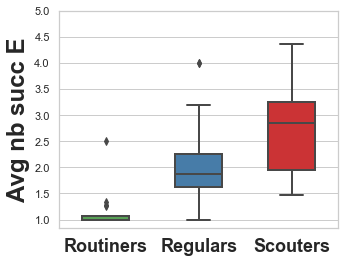

In [62]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='nb_e_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
#ax = sns.swarmplot(x='label', y='ratio_uniq', data=data_0, color=".25")
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg nb succ E", fontsize=24,fontweight= 'bold')

plt.ylim(top=5)

#plt.legend(prop={'size': 22, 'weight':'bold'})
plt.savefig('nb_e_m', dpi=300, bbox_inches='tight') 
plt.show()

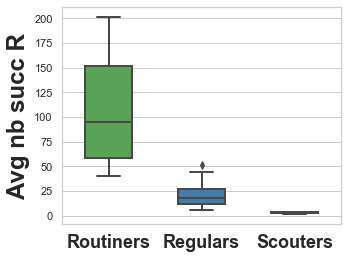

In [63]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='nb_r_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg nb succ R", fontsize=24,fontweight= 'bold')

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('nb_r_m', dpi=300, bbox_inches='tight') 
plt.show()

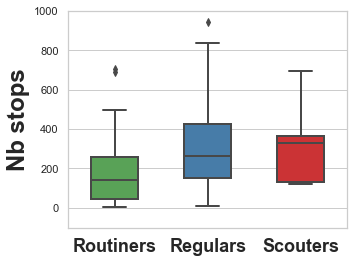

In [66]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='nb_stop', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
#ax = sns.swarmplot(x='label', y='ratio_uniq', data=data_0, color=".25")
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Nb stops", fontsize=24,fontweight= 'bold')

plt.ylim(top=1000)


#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('nb_stop', dpi=300, bbox_inches='tight') 
plt.show()

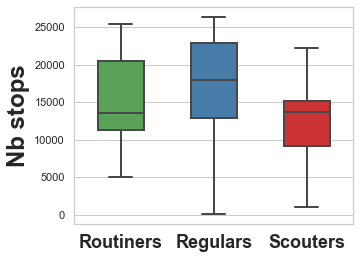

In [68]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='nb_trans', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Nb stops", fontsize=24,fontweight= 'bold')

#plt.ylim(1200,top=3200)


#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('nb_trans', dpi=300, bbox_inches='tight') 
plt.show()

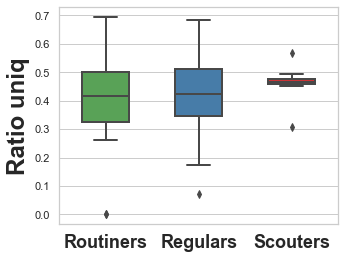

In [69]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='ratio_uniq', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Ratio uniq", fontsize=24,fontweight= 'bold')

#plt.ylim(0,5)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('ratio_uniq', dpi=300, bbox_inches='tight') 
plt.show()

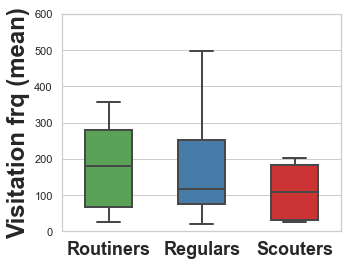

In [73]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='visit_freq_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
#ax = sns.swarmplot(x='label', y='ratio_uniq', data=data_0, color=".25")
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Visitation frq (mean)", fontsize=24,fontweight= 'bold')

plt.ylim(0,600)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('visit_freq', dpi=300, bbox_inches='tight') 
plt.show()

In [74]:
col=['label','dur_e','dur_r','dur_e_m','dur_e_sd','dur_e_cv','dur_r_m','dur_r_sd','dur_r_cv','wait_time_m','wait_time_sd','wait_time_cv']

data_0={'label':features.get('label'),'dur_e':features.get('dur_e'),'dur_r':features.get('dur_r'),'dur_e_m':features.get('dur_e_m'),'dur_e_sd':features.get('dur_e_sd'),'dur_e_cv':features.get('dur_e_cv'),'dur_r_m':features.get('dur_r_m'),'dur_r_sd':features.get('dur_r_sd'),'dur_r_cv':features.get('dur_r_cv'),'wait_time_m':features.get('wait_time_m'),'wait_time_sd':features.get('wait_time_sd'),'wait_time_cv':features.get('wait_time_cv')}
         
df = pd.DataFrame(data_0) 

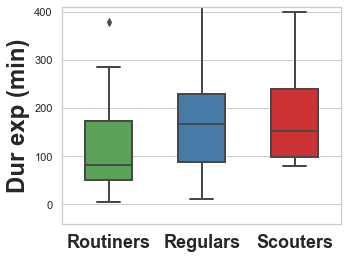

In [77]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dur_e', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dur exp (min)", fontsize=24,fontweight= 'bold')
plt.ylim(top=410)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dur_u', dpi=300, bbox_inches='tight') 
plt.show()

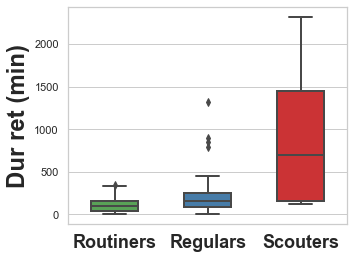

In [78]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dur_r', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dur ret (min)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,5)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dur_r', dpi=300, bbox_inches='tight') 
plt.show()

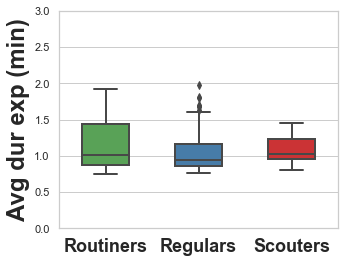

In [81]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dur_e_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg dur exp (min)", fontsize=24,fontweight= 'bold')
plt.ylim(0,3)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dur_succ_u_m', dpi=300, bbox_inches='tight') 
plt.show()

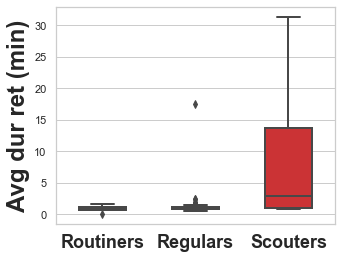

In [82]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dur_r_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg dur ret (min)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,1300)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dur_succ_r_m', dpi=300, bbox_inches='tight') 
plt.show()

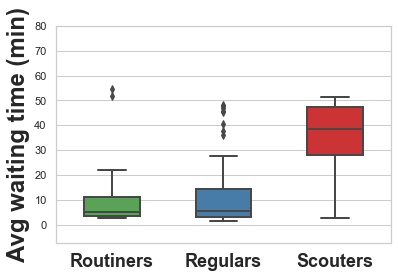

In [84]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='wait_time_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg waiting time (min)", fontsize=24,fontweight= 'bold')
plt.ylim(top=80)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('wait_time_m', dpi=300, bbox_inches='tight') 
plt.show()

In [85]:
col=['label','dist_e','dist_r','dist_e_m','dist_e_sd','dist_e_cv','dist_r_m','rg','rg_u','rg_r','jump_m','jump_sd','jump_cv','jump_total','max_dis','avg_dis']

data_0={'label':features.get('label'),'dist_e':features.get('dist_e'),'dist_r':features.get('dist_r'),'dist_e_m':features.get('dist_e_m'),'dist_e_cv':features.get('dist_e_cv'),'dist_r_m':features.get('dist_r_m'),'rg':features.get('rg'),'rg_u':features.get('rg_u'),'rg_r':features.get('rg_r'),'jump_m':features.get('jump_m'),'jump_sd':features.get('jump_sd'),'jump_cv':features.get('jump_cv'),'jump_total':features.get('jump_total'),'max_dis':features.get('max_dis'),'avg_dis':features.get('avg_dis')}
         
df = pd.DataFrame(data_0) 

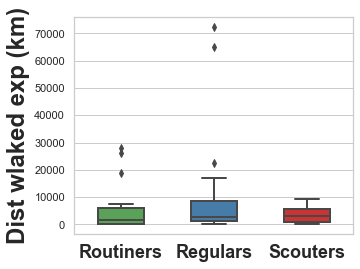

In [87]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dist_e', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dist wlaked exp (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,9)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dist_u', dpi=300, bbox_inches='tight') 
plt.show()

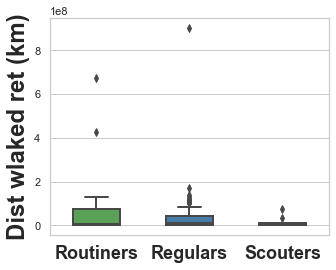

In [88]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dist_r', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dist wlaked ret (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,4.5)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dist_r', dpi=300, bbox_inches='tight') 
plt.show()

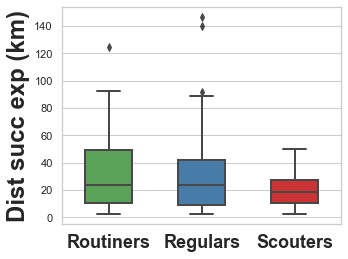

In [90]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dist_e_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dist succ exp (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,6)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dist_succ_u_m', dpi=300, bbox_inches='tight') 
plt.show()

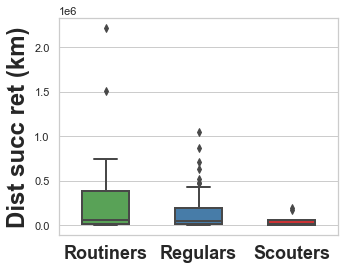

In [92]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='dist_r_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Dist succ ret (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(top=1)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('dist_succ_r_m', dpi=300, bbox_inches='tight') 
plt.show()

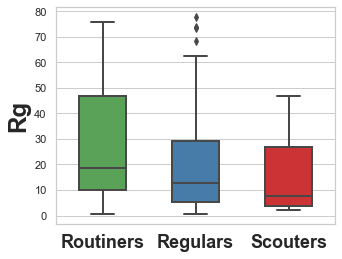

In [93]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='rg', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Rg", fontsize=24,fontweight= 'bold')
#plt.ylim(0,350)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('rg', dpi=300, bbox_inches='tight') 
plt.show()

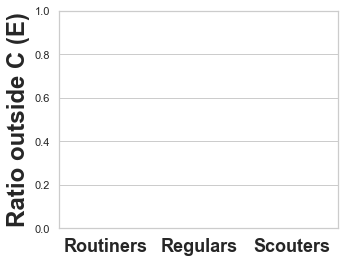

In [94]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='rg_u', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Ratio outside C (E)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,500)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('rg_u', dpi=300, bbox_inches='tight') 
plt.show()

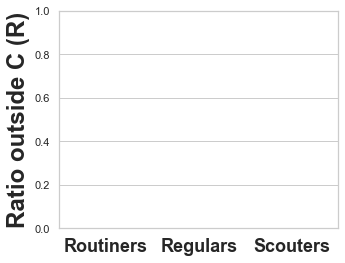

In [95]:
plt.figure(figsize=(5,4)) 
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='rg_r', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Ratio outside C (R)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,500)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('rg_r', dpi=300, bbox_inches='tight') 
plt.show()

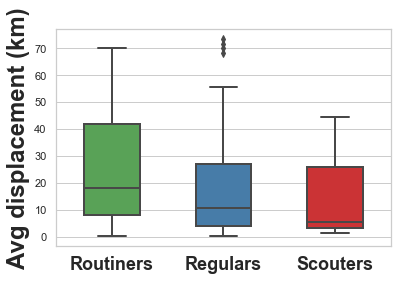

In [97]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='avg_dis', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg displacement (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,200)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('jump_m', dpi=300, bbox_inches='tight') 
plt.show()

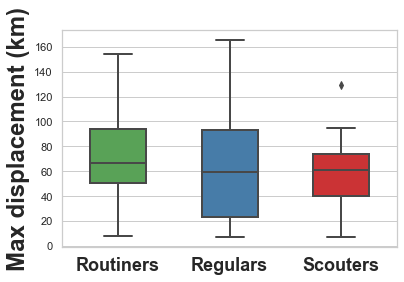

In [98]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='max_dis', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Max displacement (km)", fontsize=24,fontweight= 'bold')
#plt.ylim(0,1100)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('max_dis', dpi=300, bbox_inches='tight') 
plt.show()

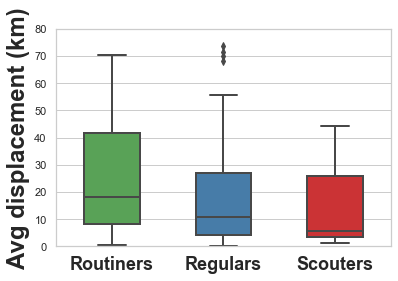

In [100]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='avg_dis', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Avg displacement (km)", fontsize=24,fontweight= 'bold')
plt.ylim(0,80)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('avg_dis', dpi=300, bbox_inches='tight') 
plt.show()

In [102]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='label', y='trans_m', data=data_0, palette=['#4daf4a','#377eb8','#e41a1c'],width=0.5,  linewidth=2,color=".1",order=["Routiners","Regulars", "Scouters"])
plt.xticks(size = 18,weight= 'bold')
plt.ylabel("Trans (km)", fontsize=24,fontweight= 'bold')
plt.ylim(0,1)

#plt.legend(prop={'size': 22, 'weight':'bold'})
#plt.savefig('trans_m', dpi=300, bbox_inches='tight') 
plt.show()

ValueError: Could not interpret input 'trans_m'

In [ ]:
    #idx=idx.reset_index()
    #fr=fr.reset_index()
    
    #fr = fr.merge(idx, on=['date','lat','lon','geohash','geohash_1','geohash_2','geohash_3','geohash_4','geohash_5','geohash_6'], how='left')
    
    #col = ['date','lat','lon','geohash','geohash_1','geohash_2','geohash_3','geohash_4','geohash_5','geohash_6']
    #fr = fr[col].apply(lambda x: x['is_exp'] = idx.loc[col]['is_exp'])
    
    
    #numbers = idx["is_exp"]
    #fr = fr.join(numbers)
    

    
    #print()
    #print(fr.iloc[np.where(fr.groupby('geohash').first())])
    
    #row,col = np.where(fr.groupby('geohash').first())
    
    #print(fr.values[row, col])#.is_exp = False
    #fr['is_exp'] = fr.iloc[col].transform(lambda x: True if x in tab_visit else False)
    
    
    #
    #idx['is_exp'] = idx['geohash'].transform(lambda x: True if x in tab_visit else False)
    #fr=fr.reset_index()
    #idx=idx.reset_index()
    #fr.loc[fr.groupby('geohash').first(), 'is_exp'] = True #idx['is_exp']
    
    #df2[df2 > 20000] = 0
    #idx = fr.reset_index().groupby('geohash').first()
    #fr = fr.transform(lambda x: True if idx else False)
    
    #np.where((fr in idx),True,fr.is_exp)
    
    #
    #print(idx)
    #fr.loc[idx] = 0


    #idx = fr.reset_index().groupby('geohash').first()
    #print(idx)
    #fr.loc[idx, 'is_exp'] = 0
    
    #first_occurences = 
    #fr['is_exp'] = fr.transform(lambda x: True if x.groupby("geohash").first() else False)
    #.reset_index()#["geohash"].values
    #fr['is_exp'] = fr.transform(lambda x: True if x in first_occurences and x.geohash not in tab_visit else False)
    
    
    #
    #Group df by column and get the first value in each group                   
    
    #print(fr.groupby("geohash").first().reset_index()["geohash"].values)
    #first_values = grouped_df.reset_index() and fr["geohash"] not in tab_visit
    #print(grouped_df)
    
    #np.where(fr["geohash"].str.contains(grouped_df) , True, False)

    
    
    #Reset indices to match format
    #first_values = grouped_df.reset_index()